# Processing the drifting buoy data

Drift tracks from instruments deployed during the MOSAiC campaign were obtained from the Arctic Data Center and saved in the folder `data/adc_dn_tracks`. The "DN" stands for "Distributed Network", which is a set of autonomous stations deployed surrounding a heavily-instrumented crewed observatory as it drifted across the Arctic from 2019-2020. 

For this project, we need quality-controlled buoy positions at hourly resolution. The raw data is at a variety of time resolutions, from 5 minutes to 12-hourly, and the resolution may change across the lifetime of a buoy. (This is not accidental--high time resolution comes at a cost of battery life. So some buoys were switched to high time resolution, for example, when storms were forecast, so that the rapid ice motion in response to the fast-moving storm system could be captured).

The files in `scripts/icedrift` contain functions for buoy processing that are in the process of being added to an open-source library. For now, since the library has not yet been listed at conda-forge or similar repositories, we'll add the package directly by adding the scripts folder to the path.

In [1]:
import sys
sys.path.append('../scripts')
from icedrift import cleaning as cln
import proplot as pplt
import pandas as pd
import cartopy.crs as ccrs

def print(*val):
    display(*val)

In [3]:
# You can run the processing code as a cell magic like this
# or run it separately in the command line
%run ../scripts/process_mosaic.py

Observations in bounding box 76 less than min size 100


/Users/dwatkin2/Documents/research/manuscripts/sampling_biases/summer-2024-utra/scripts/process_mosaic.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'longitude'] = df_subset.loc[:, 'longitude']*-1
/Users/dwatkin2/Documents/research/manuscripts/sampling_biases/summer-2024-utra/scripts/process_mosaic.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'longitude'] = df_subset.loc[:, 'longitude']*-1


n_min is nan , setting it to 10.
Observations in bounding box 4 less than min size 100
n_min is nan , setting it to 10.


/Users/dwatkin2/Documents/research/manuscripts/sampling_biases/summer-2024-utra/scripts/process_mosaic.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'longitude'] = df_subset.loc[:, 'longitude']*-1


To get more familiar with the data, try the following tasks.

1. Choose a buoy with high temporal resolution (low f_min). Use Pandas to load the buoy data from the original folder, the qc_buoys folder, and from the interp_buoys folder. How do the time series differ? Did the quality control step remove many observations? Does the lower-frequency interpolated data  appear to represent the high-frequency data well?
2. Choose a buoy with lower temporal resolution (f_min of 240). Repeat the same process as in (1). How does the data quality compare, from what you can tell? Does the interpolation process appear at this stage to add unrealistic features? (You'll get more of a feel for what's realistic or not as we go, and as we calculate other quantities from the buoy trajectories)
3. Choose two buoys. How similar are the paths that they take?
4. Find a buoy where the raw track has f_min close to 60 minutes and the qc_track is a different length. Can you find where the QC process flagged and dropped observations? Do you agree with the algorithm's choices?
5. Using Cartopy or ProPlot, make a geographic plot showing the buoy trajectories. Make the buoy tracks for DN1 and DN2 different colors. (I recommend a North Polar Stereographic map projection)


In [4]:
metadata = pd.read_csv('../data/adc_dn_tracks/DN_buoy_list_v2.csv')
freq_lookup = pd.read_csv('../data/postqc_freqs.csv')

# Print out the missing data
metadata = pd.merge(metadata, freq_lookup, left_on='Sensor ID', right_on='sensor_id', how="outer", indicator=True)
metadata = metadata.drop(columns='sensor_id').rename(columns={'freq':'Calculated Frequency'}).set_index("Sensor ID")

# missing = all_meta[all_meta['_merge'] != "both"]

## 1.

In [5]:
def buoy_data(buoy):
    """
    buoy: The Sensor ID of the buoy whose data is being fetched

    This function gets the original, quality control, and interpolated data for a given buoy
    Returns a dictionary with 'original', 'qc', and 'interp' as keys
    """

    buoy_meta = metadata.loc[buoy]
    original_file = buoy_meta['DN Station ID'] + '_' + buoy_meta['IMEI'] + '_' + buoy

    original_folder = '../data/adc_dn_tracks/'

    # There were two main deployments, one north of the Laptev Sea,
    # and a second summer deployment near the North Pole
    saveloc_dn1 = '../data/qc_buoys/mosaic_dn1/'
    saveloc_dn2 = '../data/qc_buoys/mosaic_dn2/'

    interploc_dn1 = '../data/interp_buoys/mosaic_dn1/'
    interploc_dn2 = '../data/interp_buoys/mosaic_dn2/'
    
    orig_data = pd.read_csv(original_folder + original_file + '.csv')
    orig_data['datetime'] = pd.to_datetime(orig_data['datetime'])

    saveloc, interploc = (saveloc_dn2, interploc_dn2) if buoy_meta.loc['Deployment Leg'] == 5 else (saveloc_dn1, interploc_dn1)

    qc_data = pd.read_csv(saveloc + buoy + '.csv')
    qc_data['datetime'] = pd.to_datetime(qc_data['datetime'])

    interp_data = pd.read_csv(interploc + buoy + '.csv')
    interp_data['datetime'] = pd.to_datetime(interp_data['datetime'])

    # print(all_data["original"], all_data["qc"], all_data["interp"])
    return {"original": orig_data, "qc": qc_data, "interp": interp_data}

In [67]:
def graph_data(buoy, include=["original", "qc", "interp"], showcleaned=False):
    """
    Graphs the data for a given buoy sensor id and returns the graph objects

    include: Choose which steps in the data processing to graph
    showcleaned: If True, mark the data removed by quality control with scatter points
    """
    fig = pplt.figure(refwidth=6, refheight=2, share=False)
    axs = fig.subplots(nrows=len(include), ncols=2)

    all_data = buoy_data(buoy)

    for i, name in enumerate(include):
        axs[2*i].plot(all_data[name]["datetime"], all_data[name]["latitude"], marker='.', ms=1, lw=0) # this way it's easy to see where gaps are
        axs[2*i].format(xlocator='month',
                        xformatter='%b %d',
                        title=f"{name}: Latitude of {buoy}, Length: {len(all_data[name])}", xlabel="", ylabel="latitude")

        axs[2*i+1].plot(all_data[name]['datetime'], all_data[name]["longitude"], marker='.', ms=1, lw=0)
        axs[2*i+1].format(xlocator='month',
                          xformatter='%b %d',
                          title=f"{name}: Longitude of {buoy}, Length: {len(all_data[name])}",
                          xlabel="", # Since the x ticks are dates, we don't need the extra text
                          ylabel="longitude")

        if showcleaned:
            merged = all_data['original'].merge(all_data['qc'], on='datetime', how='left', indicator=True)
            flagged = merged[merged['_merge'] == 'left_only']
            
            axs[2*i].scatter(flagged['datetime'], flagged["latitude_x"])
            axs[2*i].format(xlocator='month', xformatter='%b %d', xlabel="")

            axs[2*i+1].scatter(flagged['datetime'], flagged["longitude_x"])
            axs[2*i+1].format(xlocator='month', xformatter='%b %d', xlabel="")
        fig.format(xrotation=45)
    return fig, axs


(Figure(nrows=3, ncols=2, refwidth=6.0, refheight=2.0),
 SubplotGrid(nrows=3, ncols=2, length=6))

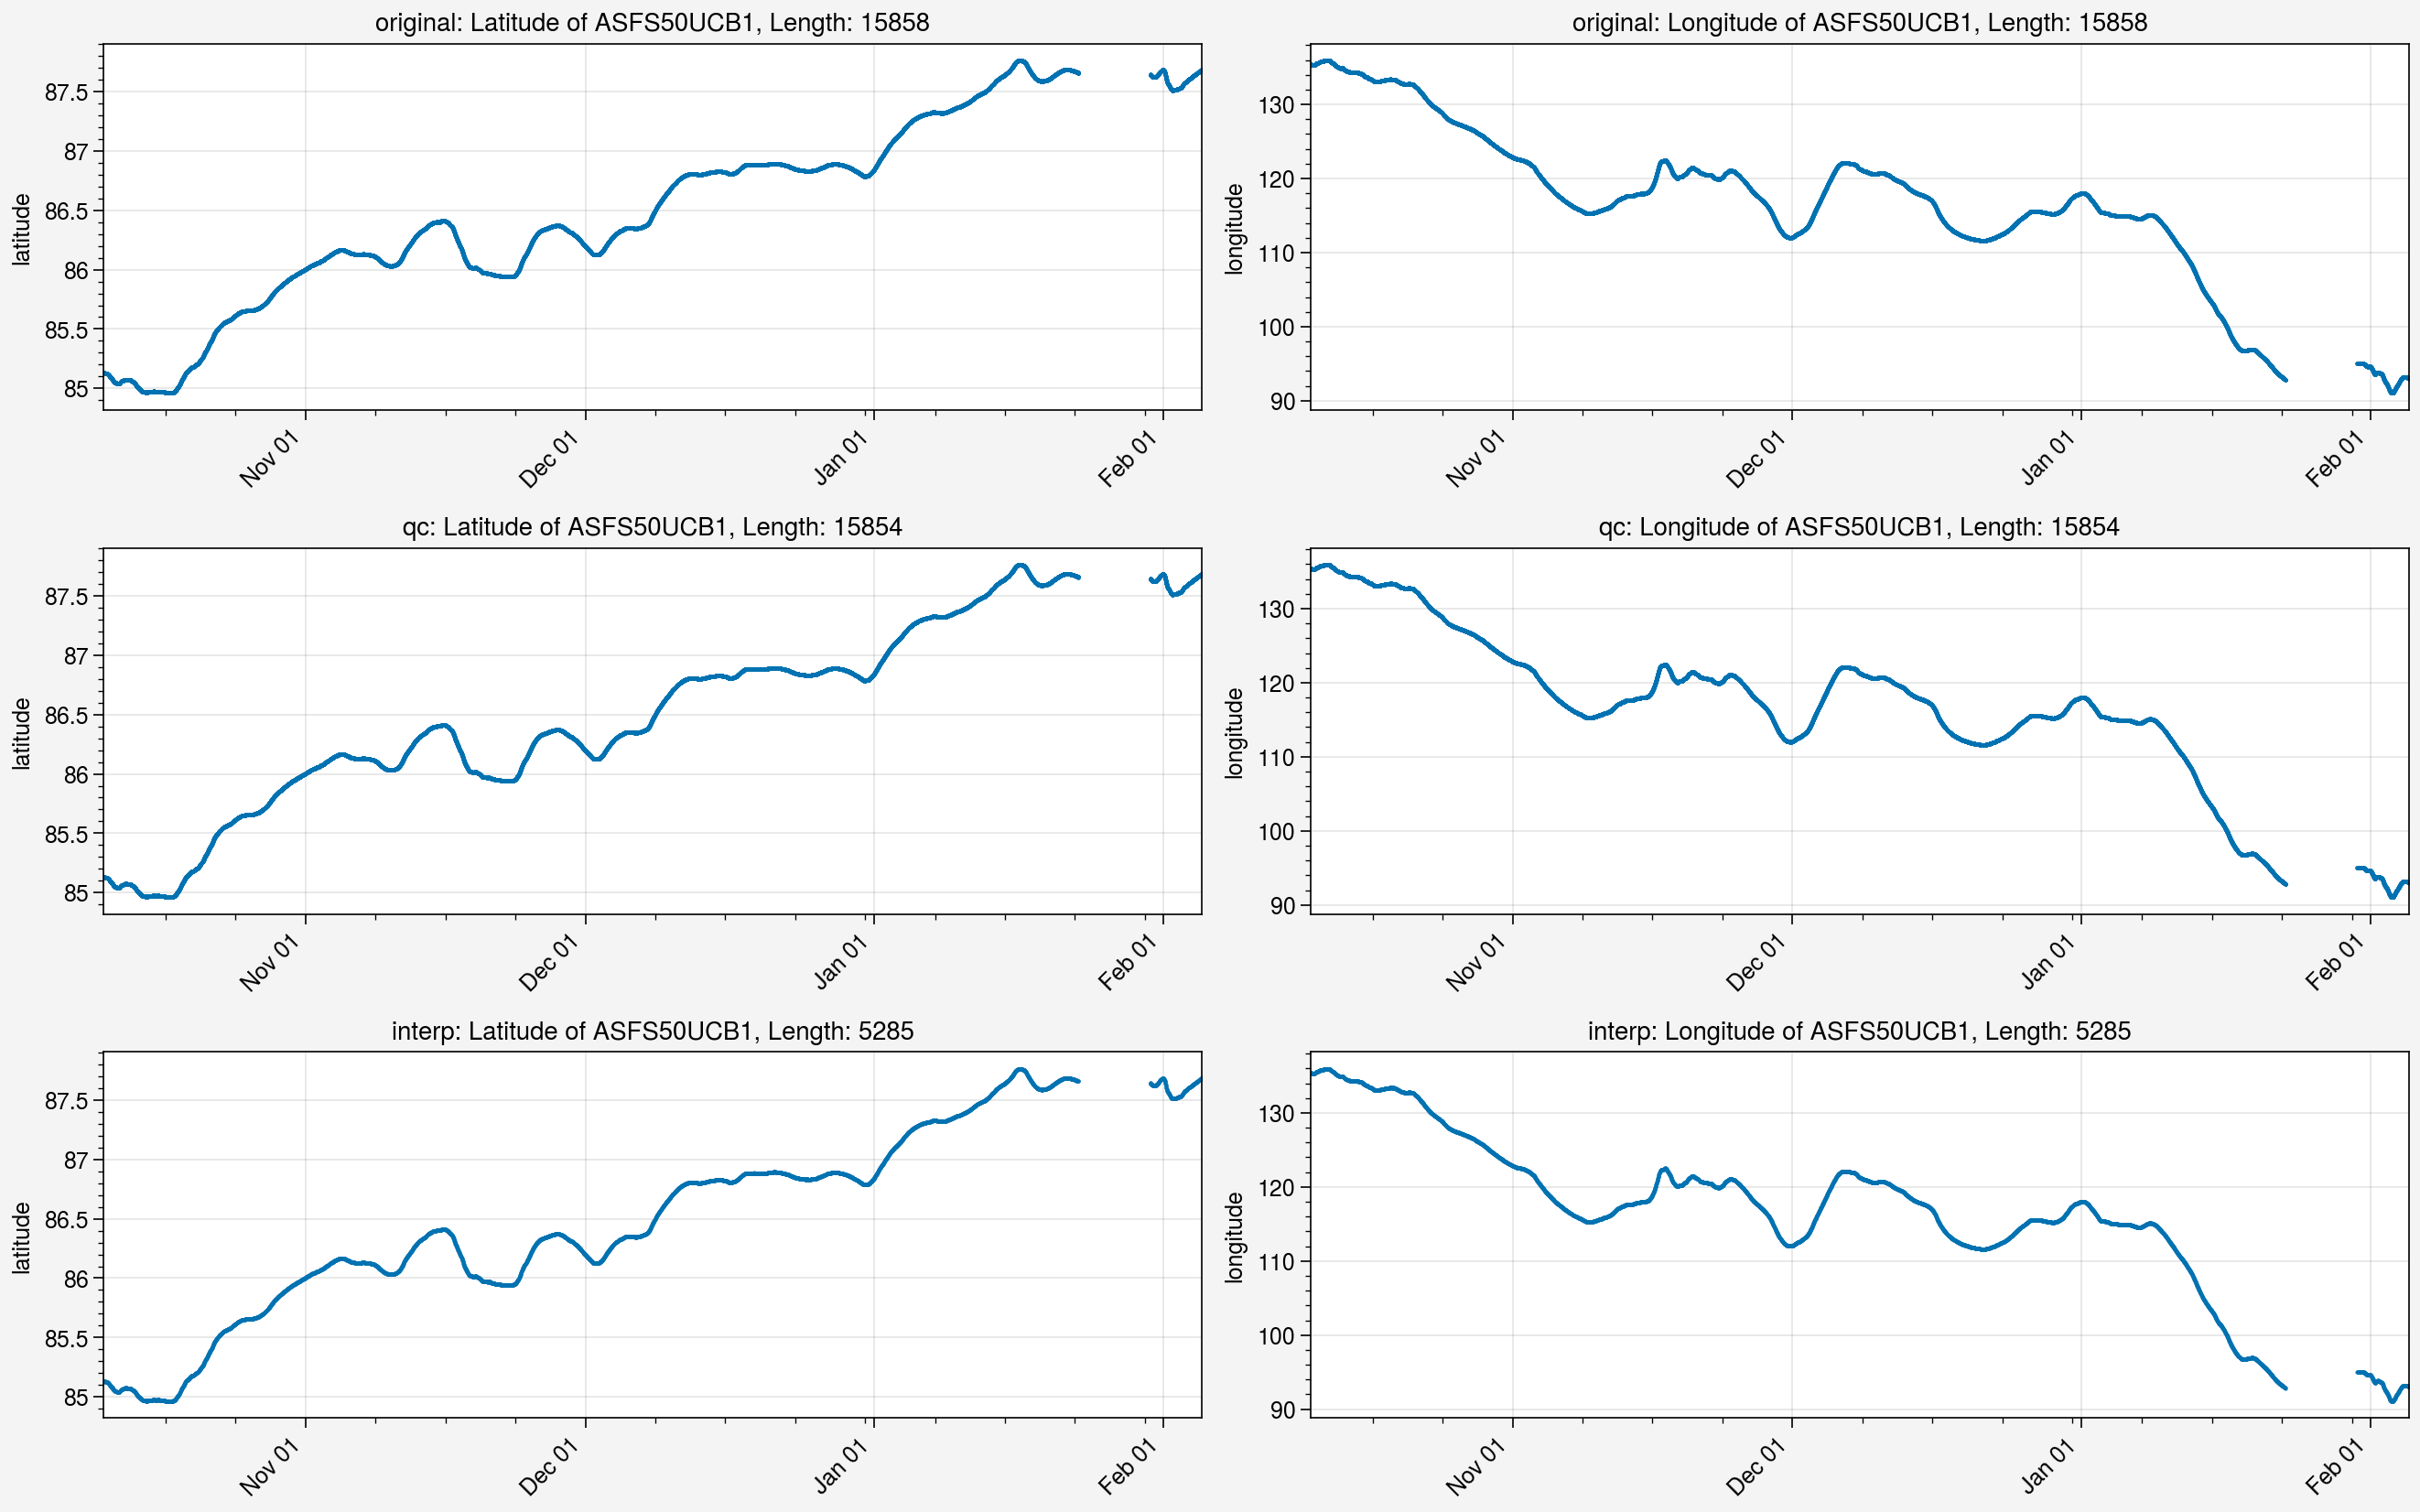

In [68]:
# print(metadata[metadata['Calculated Frequency'] == '30min'].index)
buoy_data("ASFS50UCB1")
graph_data("ASFS50UCB1")

There is significantly less data in the interpolated dataframe. Quality control didn't do much, only removing 4 data points. It seems that the interpolation function reduced granularity by a factor of 3 from 10 minute intervals to 30 minute intervals. Looking at the graphs, the low frequency data still seems to represent the high frequency data well. I'm not sure why the interpolation function reduces frequency that much though.

# 2.

(Figure(nrows=3, ncols=2, refwidth=6.0, refheight=2.0),
 SubplotGrid(nrows=3, ncols=2, length=6))

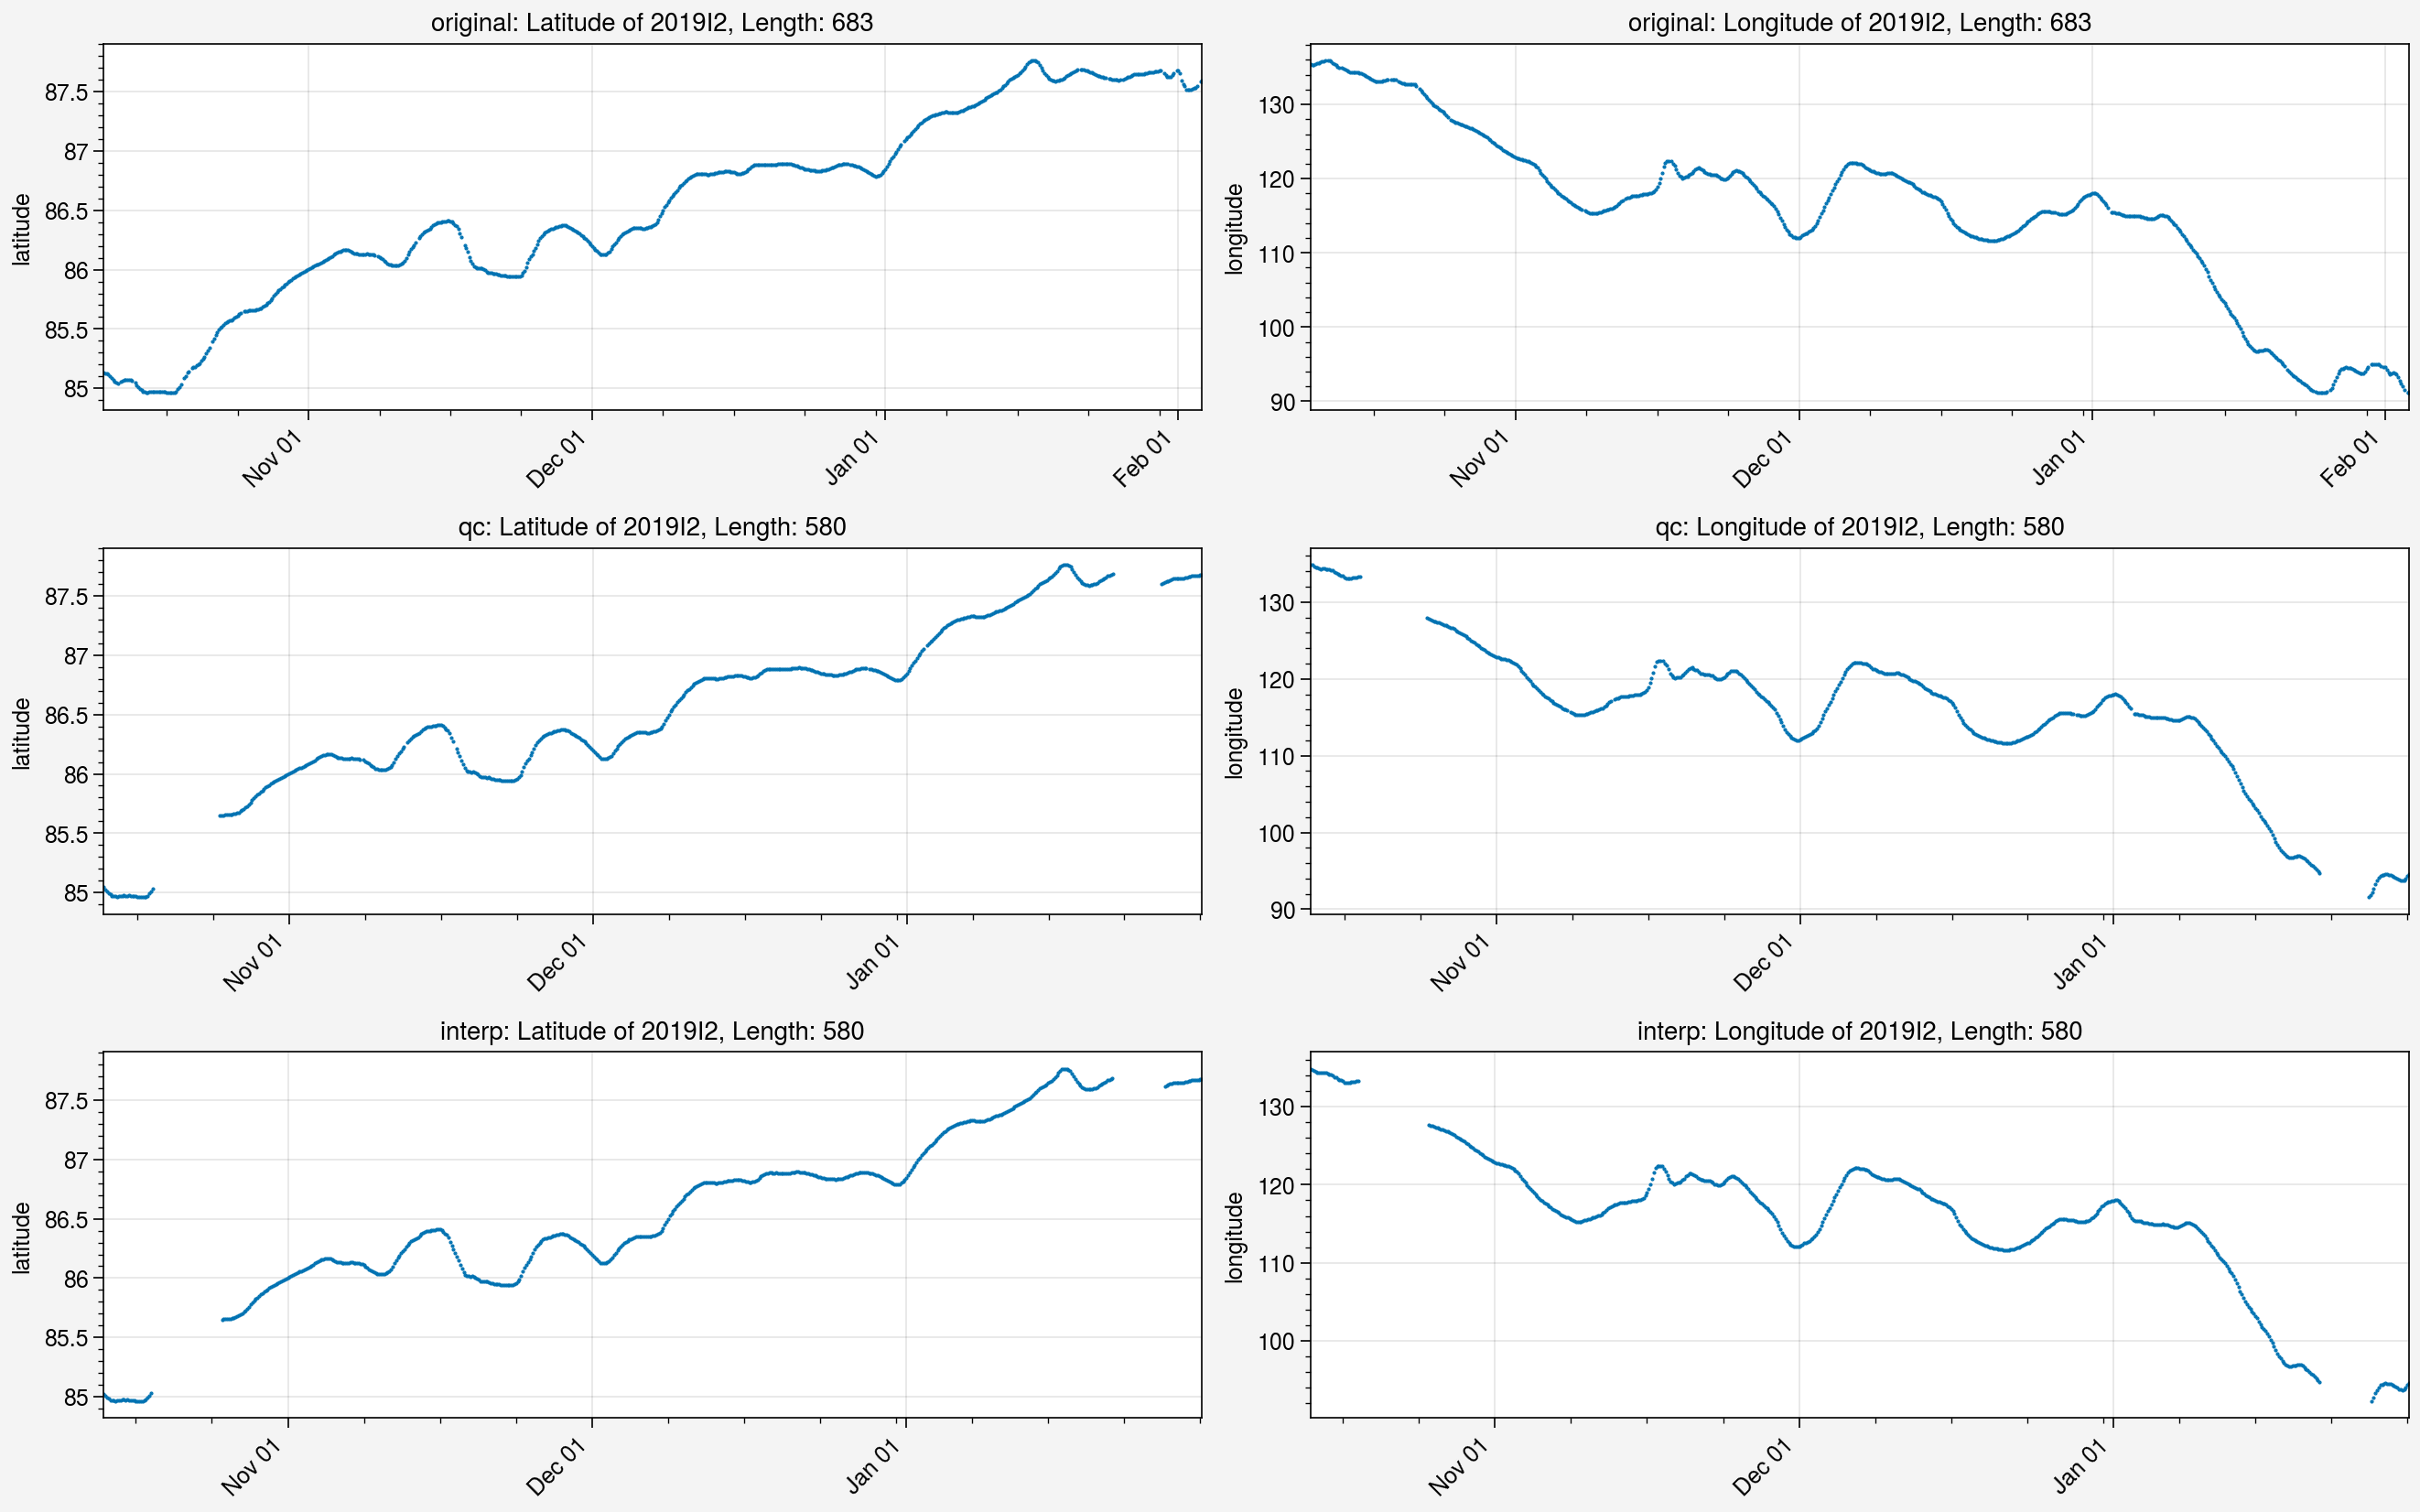

In [69]:
# print(freq_lookup[freq_lookup.freq == '240min'])
graph_data("2019I2")

It doesn't seem like interpolation added unrealistic qualities, but rather quality control. In this case, quality control added a huge jump at the beginning of the data, as if the ice teleported in latitude by more than 0.5 degrees. Also, it seems ot have removed the first and last three days of data.

Let's take a closer look to see why the QC function would have dropped those observations.


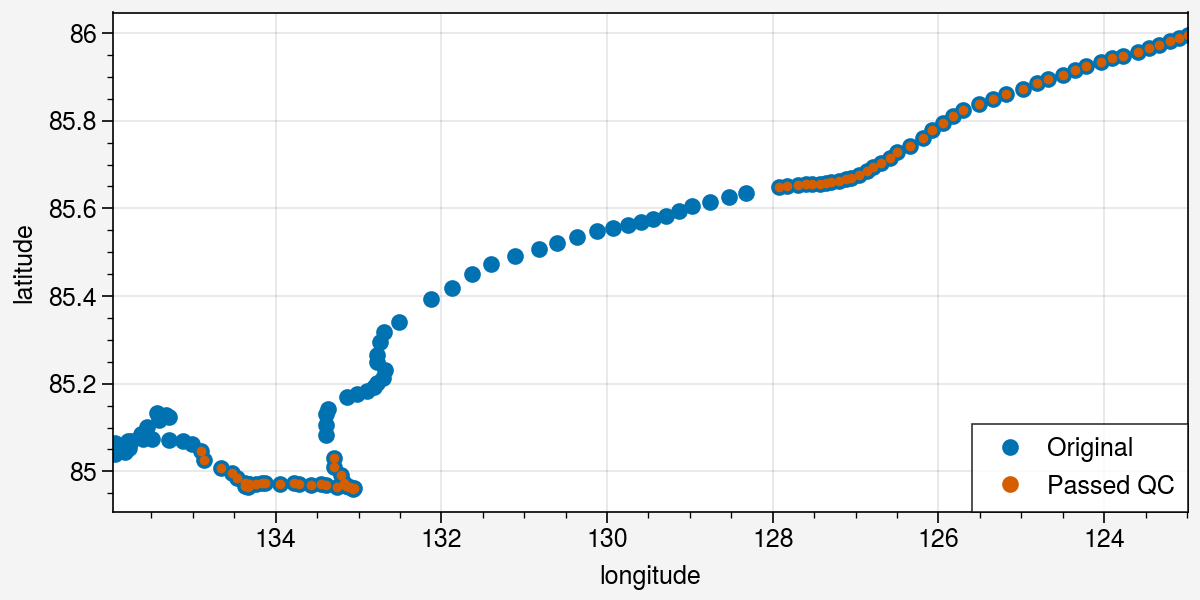

In [25]:
time_slice = slice('2019-10-01', '2019-10-31')
buoy_dfs = buoy_data('2019I2')
orig_df = buoy_dfs['original'].set_index('datetime')
qc_df = buoy_dfs['qc'].set_index('datetime')
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(orig_df.loc[time_slice, 'longitude'],
        orig_df.loc[time_slice, 'latitude'], m='.', ms=10, lw=0, label='Original')
ax.plot(qc_df.loc[time_slice, 'longitude'],
        qc_df.loc[time_slice, 'latitude'], m='.', ms=5, lw=0, label='Passed QC')
ax.legend(loc='lr', ncols=1, markersize=10)

Hmm. This is a big gap. Recall that one criterion for the QC is the gap between observations. Let's look at the time interval in between rows.

<a list of 1 Line2D objects>

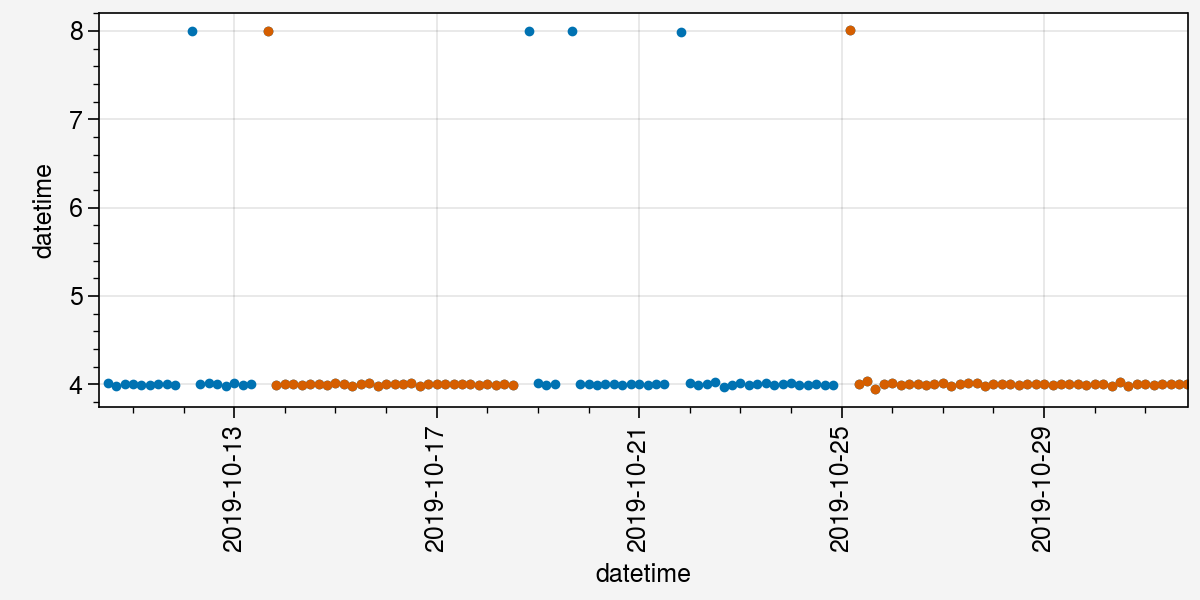

In [35]:
time_since_previous = orig_df.index.to_series() - orig_df.index.to_series().shift(1)
time_since_previous = time_since_previous.dt.total_seconds()/(60*60) # conver to hours
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(time_since_previous.loc[time_slice], marker='.', ms=5, lw=0)
ax.plot(time_since_previous.loc[qc_df.index].loc[time_slice], marker='.', ms=5, lw=0)

In [37]:
freq_lookup.set_index('sensor_id').loc['2019I2']

freq    240min
Name: 2019I2, dtype: object

OK, so this makes sense! This buoy has rather low frequency, at 4 hours. The gap frequency is set to 6 hours in the `standard_qc` function. Any gap larger than 6 hours--which in this case happens any time that a single observation is missing--triggers the flag in the `check_gaps` function. The reason for setting this to 6 hours is that for the study that I set up the code for, we needed to be able to resolve processes happening over short time intervals. In that project I was only using the buoys that had median frequency of 3 hours or faster. Interpolating to fill a 6 hour gap add non-realistic signals to the calculations. 

For this project, we can use a larger set of buoys, at least for the portion where we are looking at 12 hour and 24 hour displacements. Since the interpolation function is set to not go to higher frequencies than the sensor's median frequency, we should change the QC setting to be adaptive as well. To address this, I suggest you do the following:

1. Move the lines calling `get_frequency` to before the `standard_qc` function is called
2. Change the gap threshold to be an integer multiple of the frequency (3 is probably a good starting point here). You'll need to convert the frequency from a string into an integer, keeping track of units, apply the multiplication, then convert it back into a string with the time interval units.

# 3.

In [40]:
print(freq_lookup[freq_lookup.freq == '30min'].head(10))

,sensor_id,freq
2,2019W4,30min
3,2019T66,30min
7,2019P203,30min
8,2019P91,30min
12,ASFS50UCB4,30min
15,2019O4,30min
18,2019T67,30min
22,ASFS30UCB5,30min
24,2019O7,30min
28,ASFS30UCB4,30min


(Figure(nrows=1, ncols=2, refwidth=6.0, refheight=2.0),
 SubplotGrid(nrows=1, ncols=2, length=2))

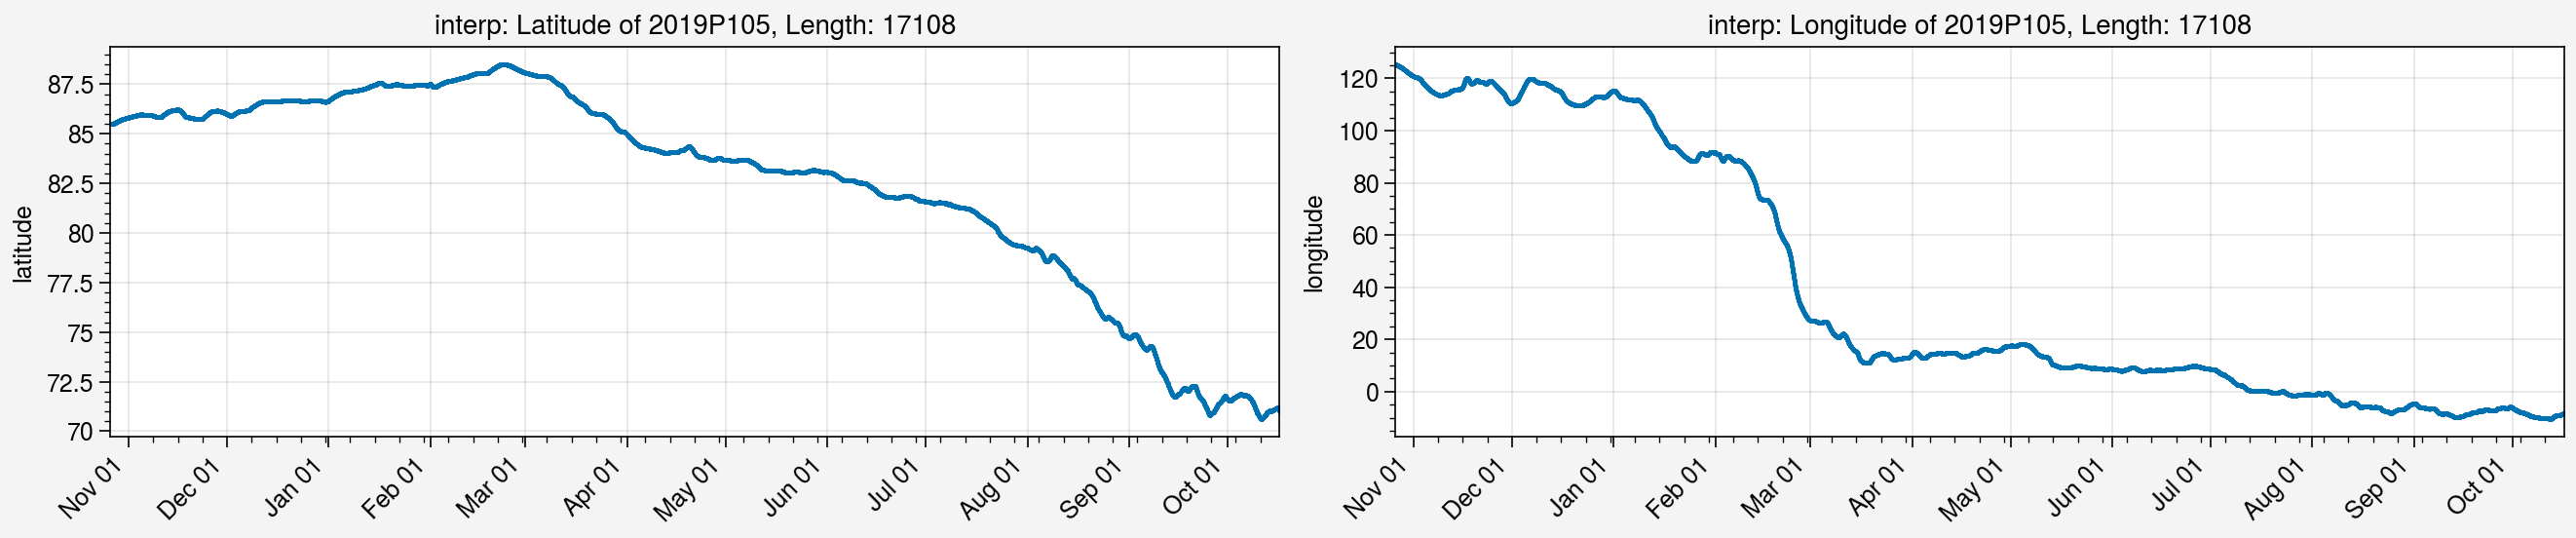

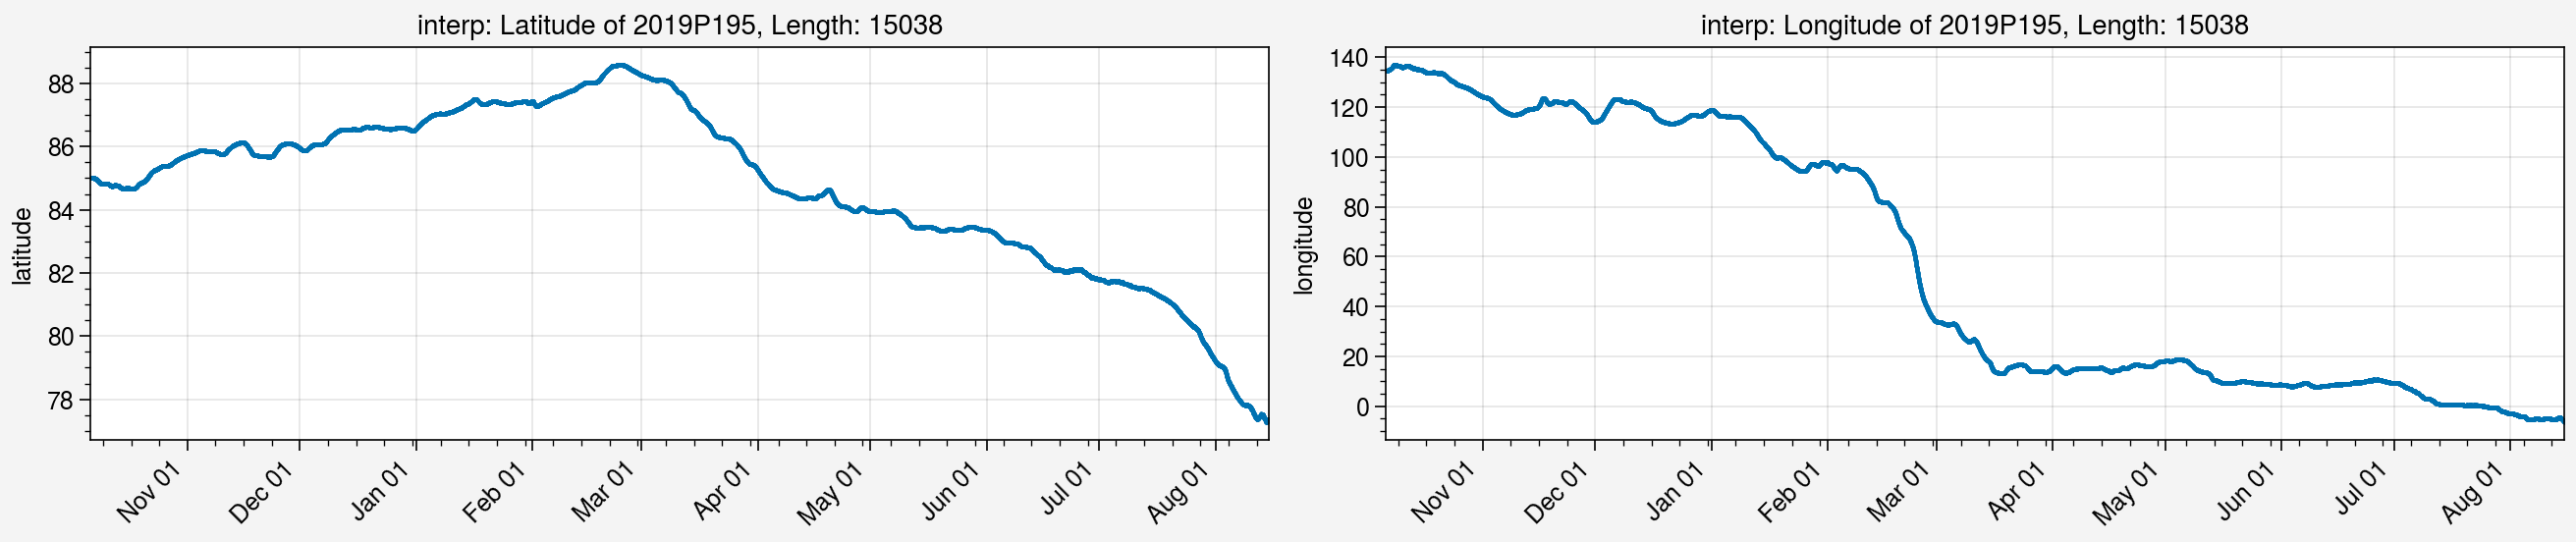

In [71]:
buoy1 = "2019P105"
buoy2 = "2019P195"

if metadata.loc[buoy1]["Deployment Leg"] != metadata.loc[buoy2]["Deployment Leg"]:
    raise "Buoys not same deployment leg"

buoy1_data = buoy_data(buoy1)["interp"].add_suffix("1")[['latitude1','longitude1']]
buoy2_data = buoy_data(buoy2)["interp"].add_suffix("2")[['latitude2','longitude2']]

# Join the data for the two buoys into one dataframe
joined_data = buoy1_data.join(buoy2_data).dropna()

graph_data(buoy1, include=["interp"])
graph_data(buoy2, include=["interp"])

In [42]:
# Calculated the correlation in latitude drift and longitude drift separately
# Used both original and differenced data

diff_data = (joined_data - joined_data.shift(1)).dropna()

lats_corr = joined_data[["latitude1","latitude2"]].corr().loc["latitude1","latitude2"]
lons_corr = joined_data[["longitude1","longitude2"]].corr().loc["longitude1","longitude2"]

diff_lats = diff_data[["latitude1","latitude2"]].corr().loc["latitude1","latitude2"]
diff_lons = diff_data[["longitude1","longitude2"]].corr().loc["longitude1","longitude2"]

print(f"Latitude correlation: {lats_corr}")
print(f"Longitude correlation: {lons_corr}")
print(f"Latitude differenced correlation: {diff_lats}")
print(f"Longitude differenced correlation: {diff_lons}")

'Latitude correlation: 0.9517051627450672'

'Longitude correlation: 0.9580686887800112'

'Latitude differenced correlation: 0.19856212263757178'

'Longitude differenced correlation: 0.04005815736913272'

The two buoys followed very similar trajectories, likely as a result of being released at around the same location. However, their individual velocities at any given time don't seem to be correlated. This is probably due to the variability introduced by the short 30 minute timeframe?

In [45]:
from icedrift.analysis import compute_velocity
buoy1_data = buoy_data(buoy1)["interp"]
buoy2_data = buoy_data(buoy2)["interp"]
buoy1_data = compute_velocity(buoy1_data.set_index('datetime'))
buoy2_data = compute_velocity(buoy2_data.set_index('datetime'))

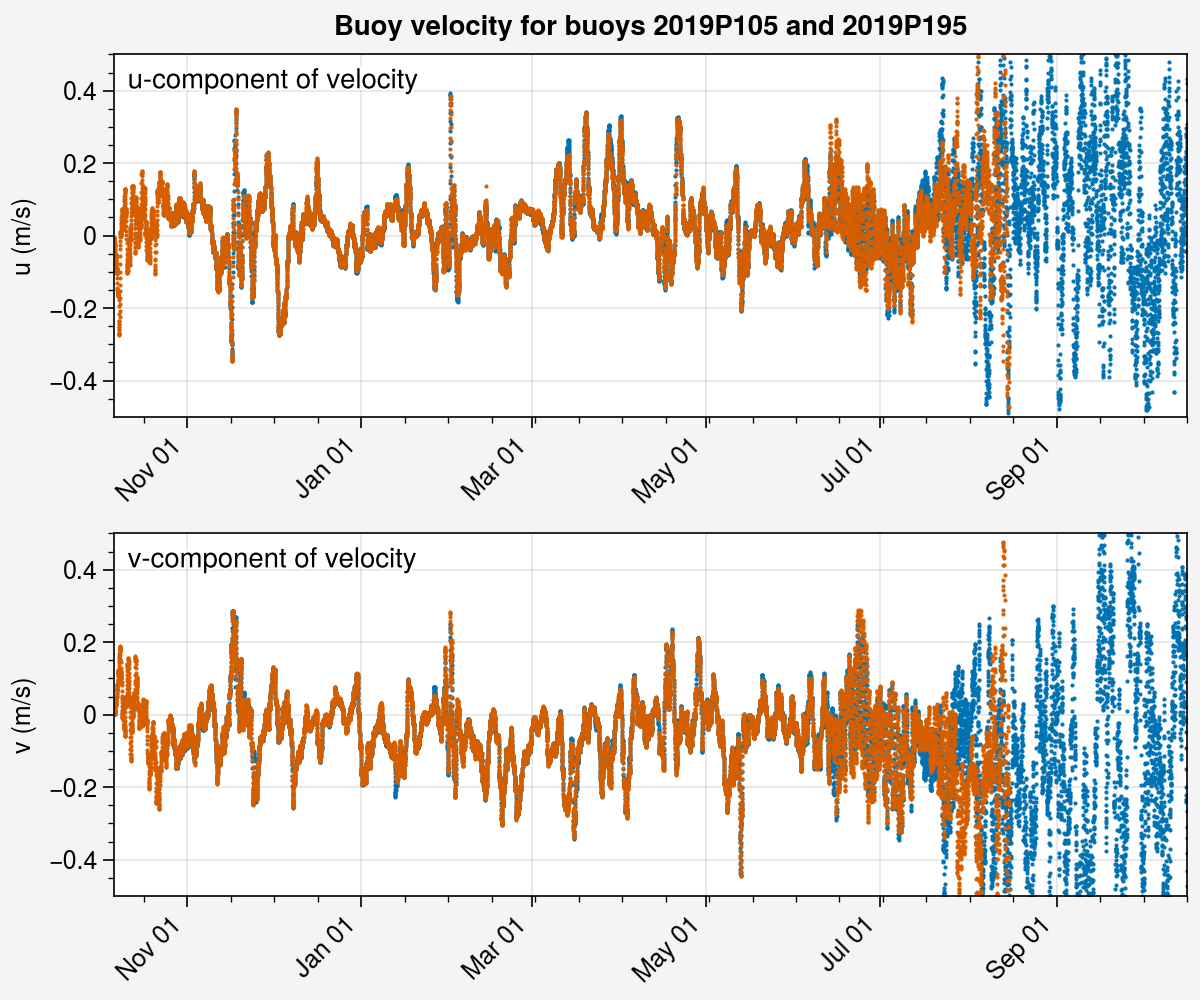

In [58]:
fig, axs = pplt.subplots(width=6, height=5, nrows=2, share=False)
for ax, component in zip(axs, ['u', 'v']):
    ax.plot(buoy1_data[component], lw=0, marker='.', ms=1)
    ax.plot(buoy2_data[component], lw=0, marker='.', ms=1)
    ax.format(ultitle=component + '-component of velocity', xrotation=45, xformatter='%b %d',
              xlabel='', ylabel=component + ' (m/s)', ylim=(-0.5, 0.5))
fig.format(suptitle='Buoy velocity for buoys {b1} and {b2}'.format(b1=buoy1, b2=buoy2))


Quick look at correlation. Note: for a full analysis of correlation, you'd need to do a significance test accounting for the fact that the velocity data are highly autocorrelated, so the effective sample size is lower than the length of the time series.

In [59]:
buoy1_data.corrwith(buoy2_data, method='spearman')

x_stere             0.999379
y_stere             0.999937
data_gap_minutes   -0.004888
longitude           0.998409
latitude            0.998099
x                   0.999379
y                   0.999937
u                   0.872920
v                   0.865510
speed               0.929256
dtype: float64

# 4.

In [72]:
# Get only the buoys that have frequency 60 and have been affected by quality control

freq60buoys = metadata[metadata['Calculated Frequency'] == '60min']

freq60buoys = freq60buoys.assign(orig_length = [len(buoy_data(name)["original"]) for name in freq60buoys.index])
freq60buoys = freq60buoys.assign(qc_length = [len(buoy_data(name)["qc"]) for name in freq60buoys.index])

print(freq60buoys[freq60buoys.orig_length != freq60buoys.qc_length].index)

Index(['2019R9', '2019S94', '2019S96', '2019S84', '2019V2', '2019V3', '2019V4',
       '2019S86', '2019T69', '2019P136', '2019P150', '2019P151', '2019P159',
       '2019P158', '2019P152', '2019P155', '2019P156', '2019P123', '2019P128',
       '2019P113', '2019P112', '2019P119', '2019P114', '2019P139', '2019P144',
       '2019P124', '2019P125', '2019P157', '2019P127', '2020E2', '2020S99',
       '2020E3', '2020P225', '2020P228', '2020S97', '2020P213', '2020P160',
       '2020P162', '2020P180', '2020P237', '2020S105', '2020S106', '2020S107',
       '2020S108', '2020S98', '2020P170', '2020P171', '2020P172', '2020P173',
       '2020P175', '2020P177', '2020P181', '2020P229', '2020P231', '2020P234',
       '2020P233', '2020P236'],
      dtype='object', name='Sensor ID')

(Figure(nrows=3, ncols=2, refwidth=6.0, refheight=2.0),
 SubplotGrid(nrows=3, ncols=2, length=6))

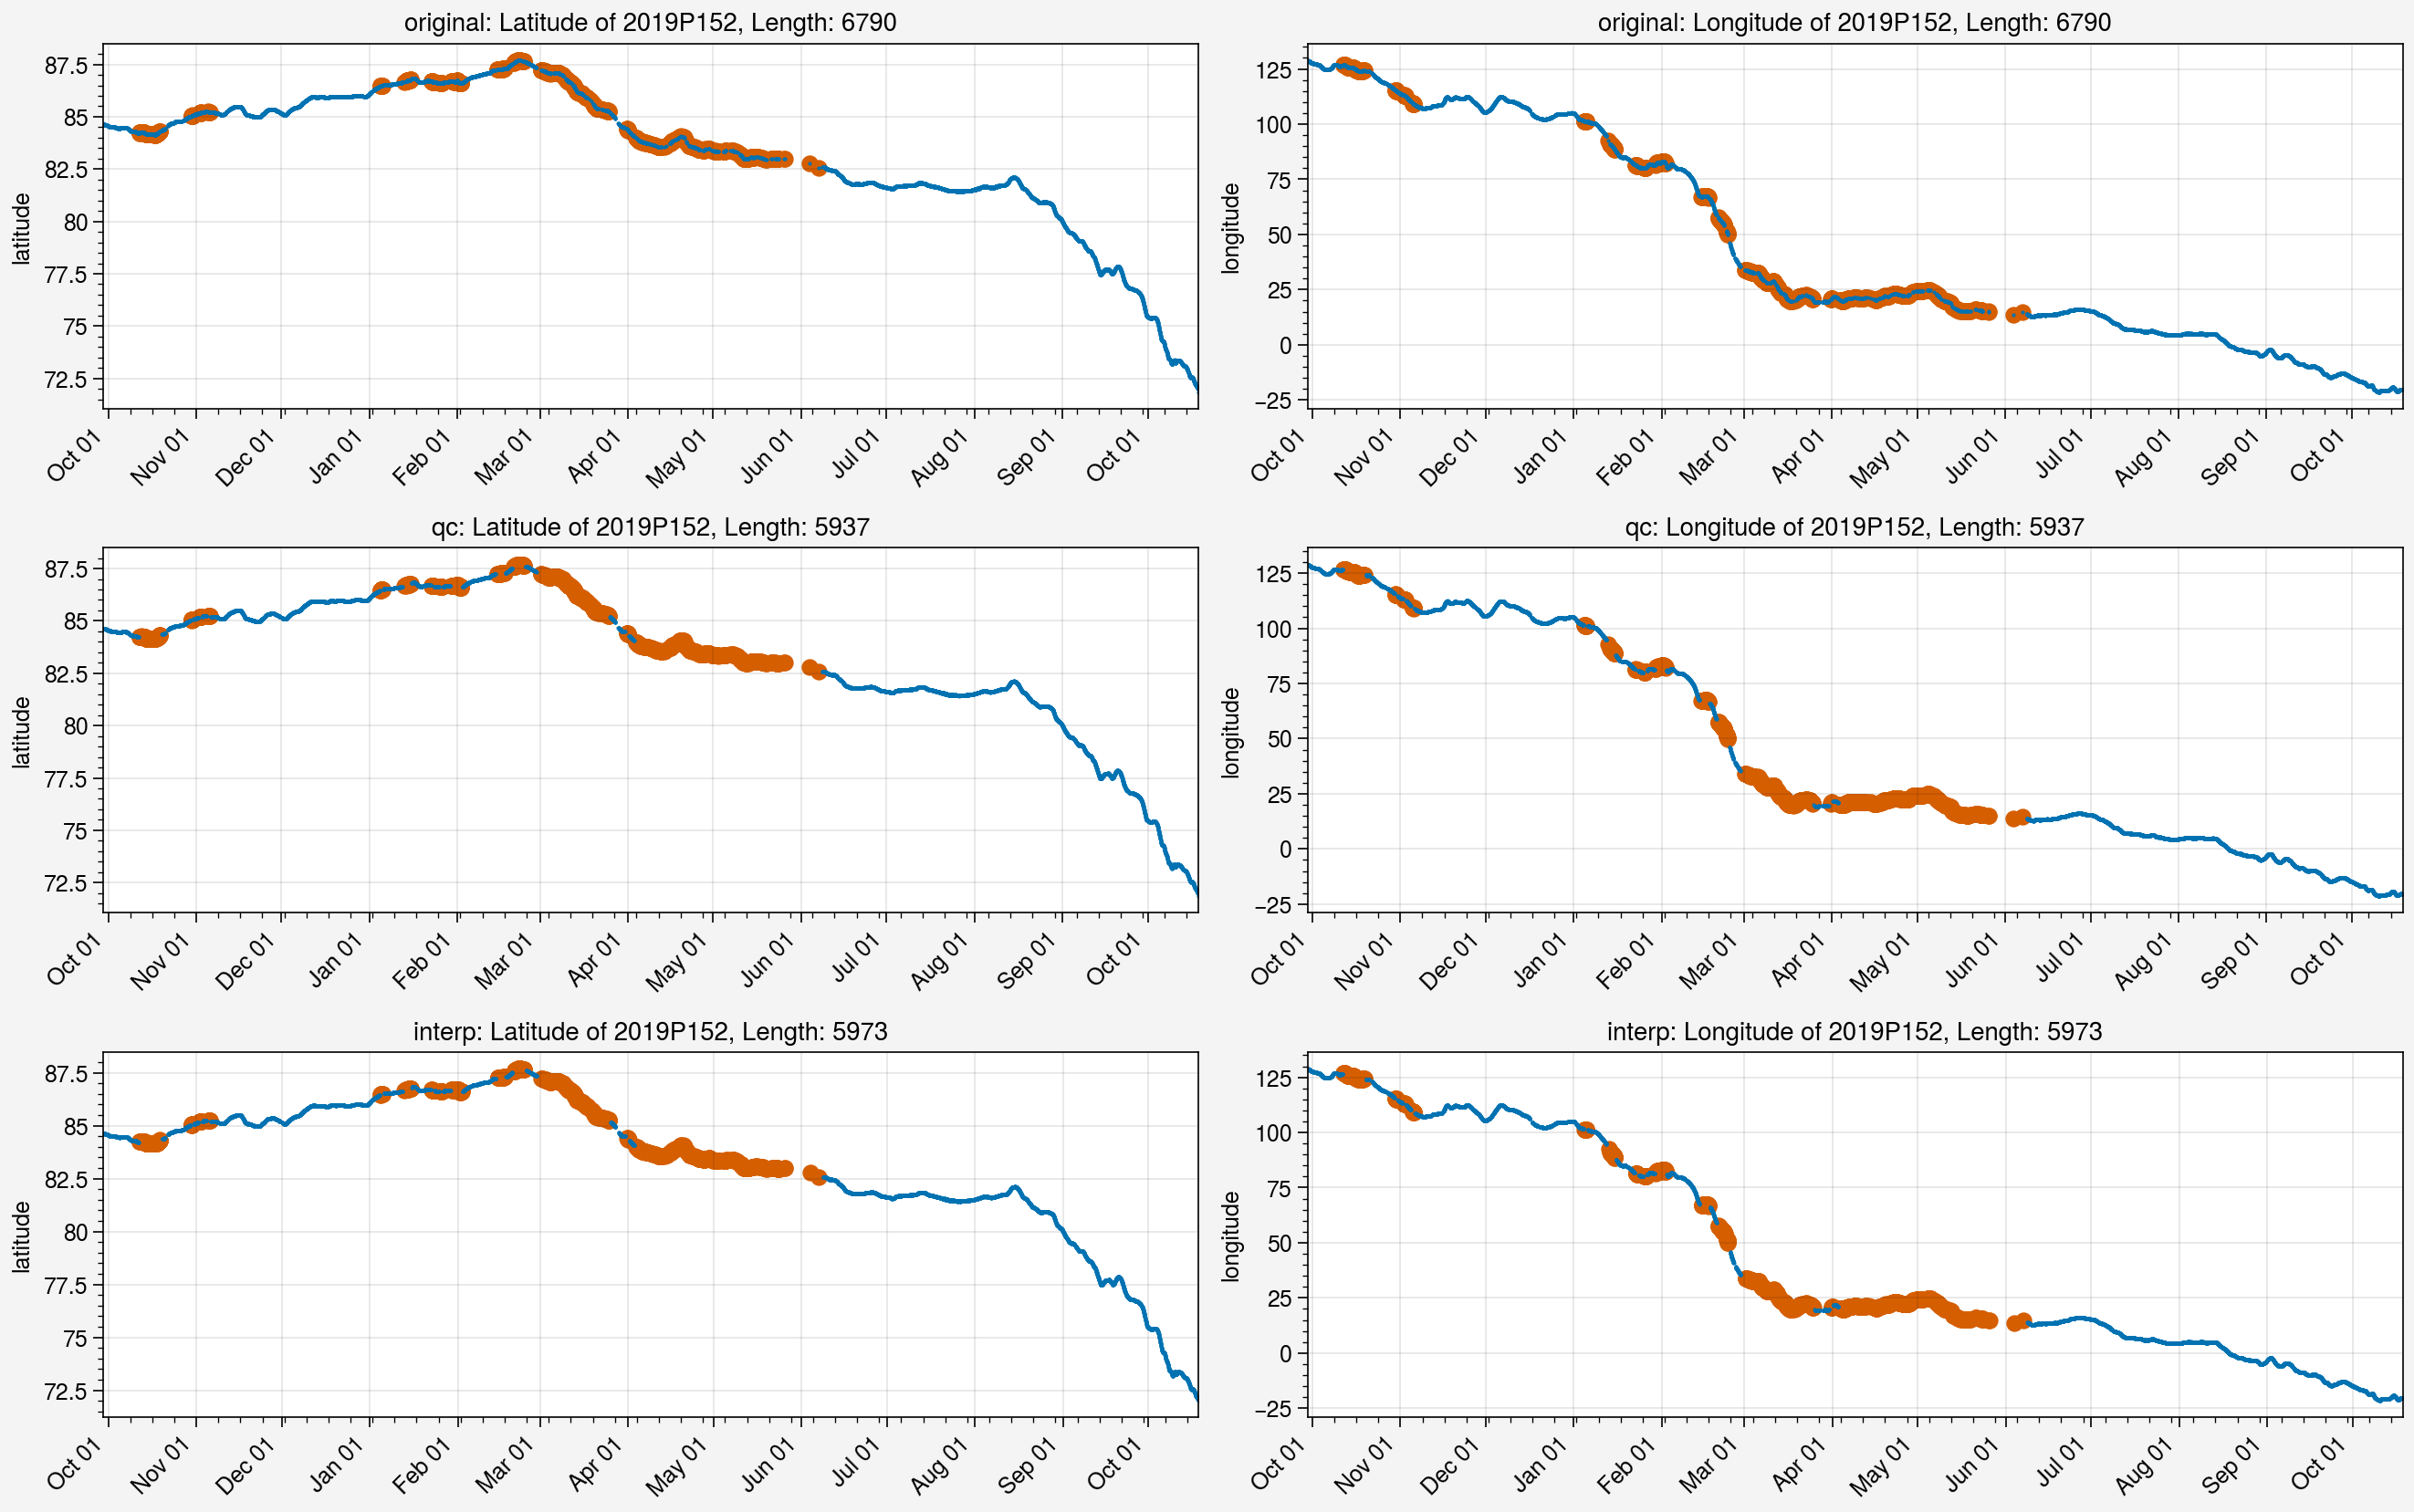

In [73]:
# I graphed a random buoy chosen from above and set the graphs to show which points were removed

buoy = '2019P152'
graph_data(buoy, showcleaned=True)


The data quality control algorithm seems to do smoothing. There likely is noise created by atmospheric or other fluctuations that are picked up by the buoy but not actually representative of ice motion. The smoothing seems to remove the noise. I'm not sure I agree with the algorithm in the period after 2020-04-08 though. It seems to remove a consistent trend of data showing the ice moving east.

# 5.

/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


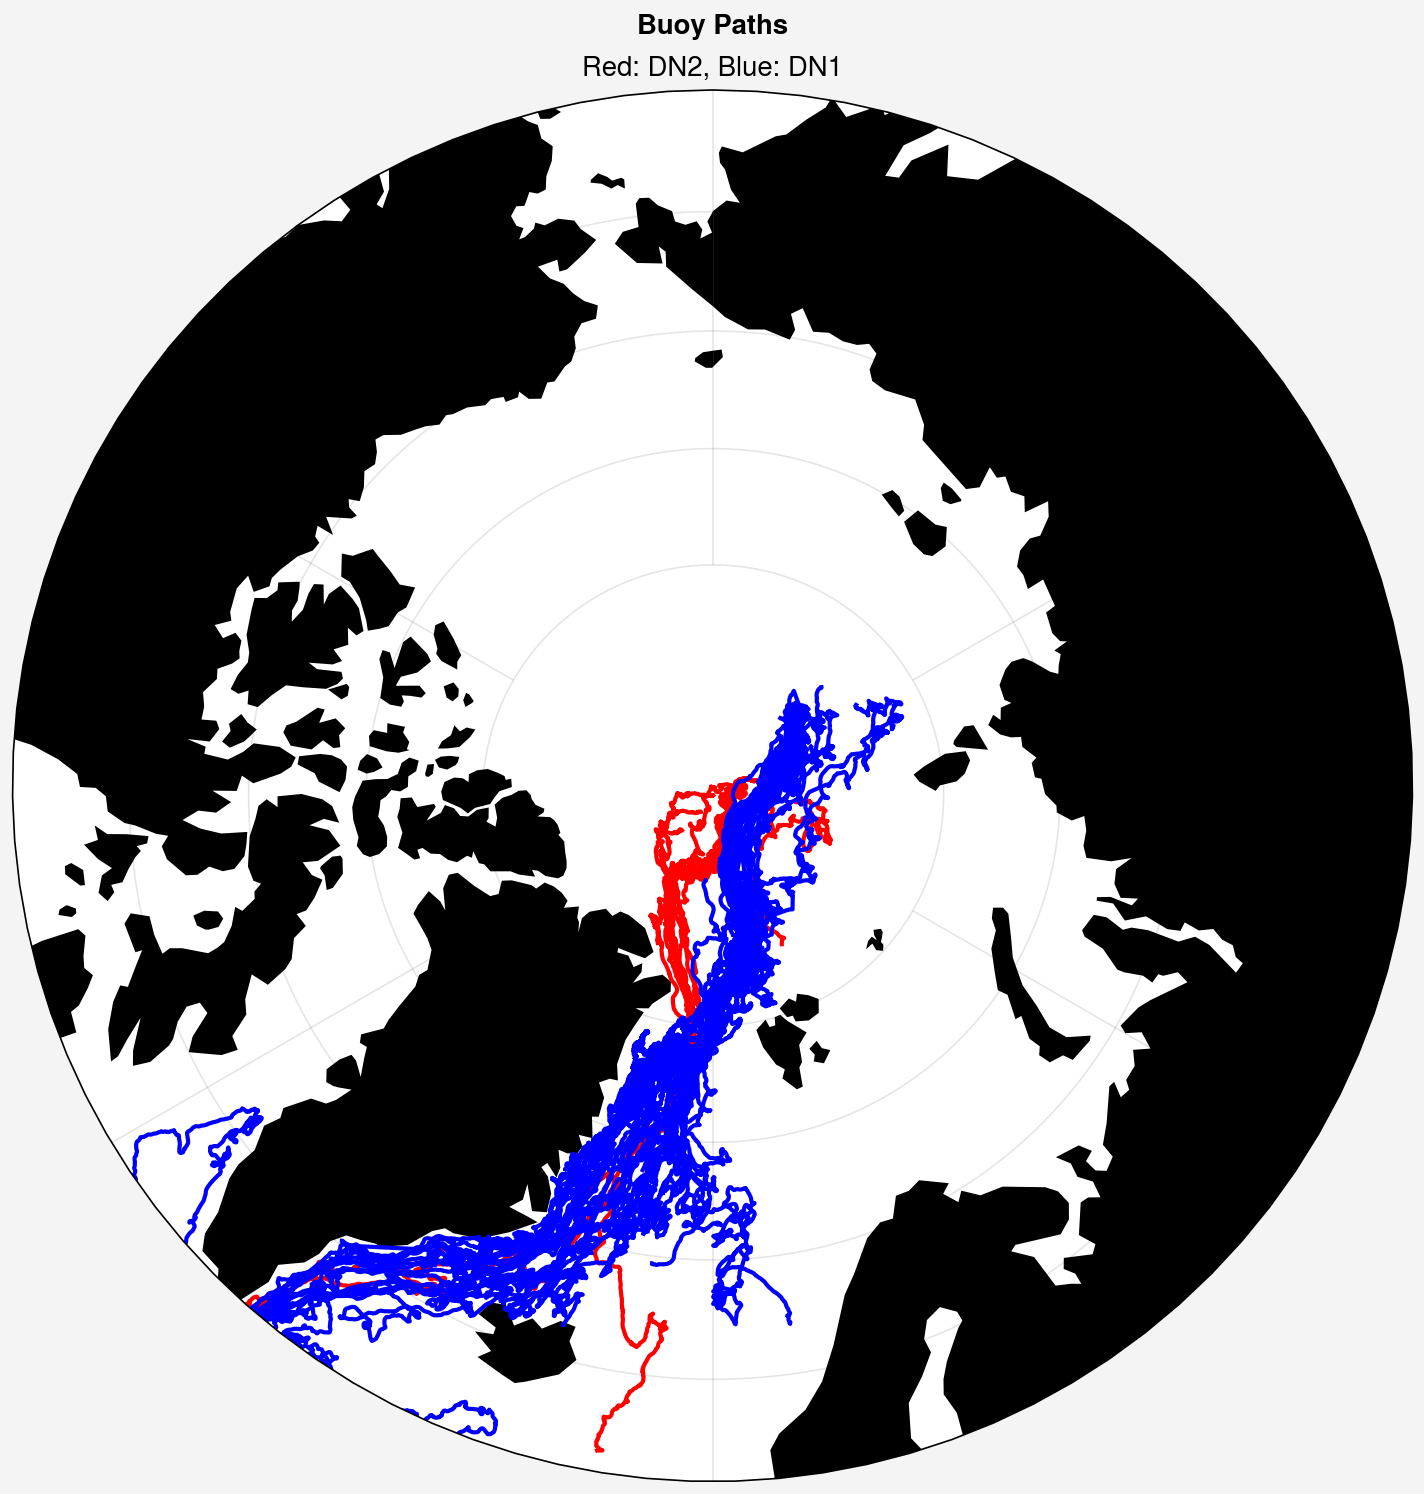

In [18]:
# Pole-centered map projections

fig, axs = pplt.subplots(ncols=1, refwidth=7, proj=('npstere'))
fig.format(suptitle='Buoy Paths')
axs.format(land=True)

dn1 = os.listdir("../data/interp_buoys/mosaic_dn1")
dn2 = os.listdir("../data/interp_buoys/mosaic_dn2")

axs[0].format(boundinglat=60, title='Red: DN2, Blue: DN1')

# Plot dn2 buoys in red, dn1 buoys in blue
for buoy in [i[:-4] for i in dn2]:
    axs[0].plot(buoy_data(buoy)['interp']['longitude'], buoy_data(buoy)['interp']['latitude'], color="red")
for buoy in [i[:-4] for i in dn1]:
    axs[0].plot(buoy_data(buoy)['interp']['longitude'], buoy_data(buoy)['interp']['latitude'], color="blue")
